In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import json
import os

## Loading Data

In [2]:
# Load dataset for autoencoder training

df = pd.read_csv("../data/hand_landmarks_dataset_normalized_to_the_wrist.csv")
feature_columns = [col for col in df.columns if col.startswith(("x", "y"))]
X = df[feature_columns].values.astype(np.float32)

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")

Dataset loaded: 908 samples, 42 features


## Defining Essential functions

In [4]:
def create_autoencoder(input_dim):
    """
    Improved autoencoder with normalization, dropout, and better initialization.
    """
    model = tf.keras.models.Sequential(
        [
            # Input with noise for robustness
            tf.keras.layers.Input((input_dim,), name="input_layer"),
            tf.keras.layers.GaussianNoise(0.05, name="input_noise"),
            # Encoder
            tf.keras.layers.Dense(
                64, kernel_initializer="he_normal", name="encoder_dense1"
            ),
            tf.keras.layers.BatchNormalization(name="encoder_bn1"),
            tf.keras.layers.LeakyReLU(negative_slope=0.1, name="encoder_act1"),
            tf.keras.layers.Dense(
                32, kernel_initializer="he_normal", name="encoder_dense2"
            ),
            tf.keras.layers.BatchNormalization(name="encoder_bn2"),
            tf.keras.layers.LeakyReLU(negative_slope=0.1, name="encoder_act2"),
            # Bottleneck
            tf.keras.layers.Dense(
                8,
                activation=None,
                kernel_initializer="he_normal",
                activity_regularizer=tf.keras.regularizers.L1(1e-5),
                name="bottleneck",
            ),
            # Decoder
            tf.keras.layers.Dense(
                32, kernel_initializer="he_normal", name="decoder_dense1"
            ),
            tf.keras.layers.BatchNormalization(name="decoder_bn1"),
            tf.keras.layers.LeakyReLU(negative_slope=0.1, name="decoder_act1"),
            tf.keras.layers.Dense(
                64, kernel_initializer="he_normal", name="decoder_dense2"
            ),
            tf.keras.layers.BatchNormalization(name="decoder_bn2"),
            tf.keras.layers.LeakyReLU(negative_slope=0.1, name="decoder_act2"),
            # Output
            tf.keras.layers.Dense(input_dim, activation="linear", name="output_layer"),
        ]
    )

    # Use AdamW + Huber loss for stability
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5),
        loss=tf.keras.losses.Huber(),
    )

    return model


def train_autoencoder_model(X, epochs=20):
    """
    Train the autoencoder
    """
    X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

    autoencoder = create_autoencoder(X.shape[1])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True
        )
    ]

    history = autoencoder.fit(
        X_train,
        X_train,
        validation_data=(X_val, X_val),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1,
    )

    return autoencoder, X_train, history


def calculate_threshold(autoencoder, X_train, percentile=95):
    """
    Calculate reconstruction error threshold
    """
    reconstructions = autoencoder.predict(X_train, verbose=0)
    errors = np.mean(np.square(X_train - reconstructions), axis=1)
    threshold = np.percentile(errors, percentile)

    print(f"Threshold calculated: {threshold:.6f}")
    return threshold, errors


def save_autoencoder_model(autoencoder, threshold):
    """
    Save autoencoder and threshold
    """
    os.makedirs("../models", exist_ok=True)

    autoencoder.save("../models/autoencoder.keras")

    with open("../models/threshold.json", "w") as f:
        json.dump({"threshold": float(threshold)}, f)

    print("Autoencoder and threshold saved!")


def plot_kfold_results(fold_histories, best_model, best_threshold):
    """
    Plot k-fold training results
    """
    os.makedirs("../models/autoencoder_plots", exist_ok=True)

    # Plot all fold histories
    plt.figure(figsize=(10, 6))
    for i, history in enumerate(fold_histories):
        plt.plot(history.history["loss"], alpha=0.7, label=f"Fold {i+1} Train")
        plt.plot(
            history.history["val_loss"],
            alpha=0.7,
            linestyle="--",
            label=f"Fold {i+1} Val",
        )
    plt.title("K-Fold Training History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(
        "../models/autoencoder_plots/kfold_training_history.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Plot reconstruction errors for best model
    plt.figure(figsize=(8, 6))
    reconstructions = best_model.predict(X_temp, verbose=0)
    errors = np.mean(np.square(X_temp - reconstructions), axis=1)
    plt.hist(errors, bins=50, alpha=0.7)
    plt.axvline(
        best_threshold,
        color="red",
        linestyle="--",
        label=f"Threshold: {best_threshold:.6f}",
    )
    plt.title("Reconstruction Errors (Best Model)")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.savefig(
        "../models/autoencoder_plots/reconstruction_errors.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


def convert_to_tflite(autoencoder):
    """
    Convert autoencoder to TFLite
    """
    os.makedirs("../models/tflite", exist_ok=True)

    converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
    tflite_model = converter.convert()

    with open("../models/tflite/autoencoder.tflite", "wb") as f:
        f.write(tflite_model)

    print("Autoencoder converted to TFLite!")

## Model Summery

In [5]:
# This model creation is only for seeing the model summery before training
model = create_autoencoder(input_dim=X.shape[1])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_noise (GaussianNoise)     │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn1                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_act1 (LeakyReLU)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn2                     │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_act2 (LeakyReLU)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense1 (Dense)          │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn1                     │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_act1 (LeakyReLU)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense2 (Dense)          │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_act2 (LeakyReLU)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 42)             │         2,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,994 (42.95 KB)

 Trainable params: 10,610 (41.45 KB)

 Non-trainable params: 384 (1.50 KB)

## K-fold Cross Validation Training

In [6]:
# Keep test set separate (20% for final evaluation)
print("Splitting data into train/validation (80%) and test (20%) sets...")
X_temp, X_test = train_test_split(X, test_size=0.2, random_state=42)

print(f"Training/Validation data: {X_temp.shape}")
print(f"Test data: {X_test.shape}")

# K-fold cross validation setup
print("\nStarting 5-fold cross validation...")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
fold_models = []
fold_histories = []
fold_thresholds = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_temp)):
    print(f"\n{'='*50}")
    print(f"Training Fold {fold + 1}/5")
    print(f"{'='*50}")

    # Split data for this fold
    X_train, X_val = X_temp[train_idx], X_temp[val_idx]

    print(f"Train samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")

    # Create and train autoencoder
    print("Creating and training autoencoder...")
    autoencoder = create_autoencoder(X.shape[1])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True
        )
    ]

    history = autoencoder.fit(
        X_train,
        X_train,
        validation_data=(X_val, X_val),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=0,
    )

    fold_histories.append(history)

    # Calculate threshold and evaluate
    threshold, _ = calculate_threshold(autoencoder, X_train)
    fold_thresholds.append(threshold)

    # Evaluate model (validation loss)
    val_loss = min(history.history["val_loss"])
    cv_scores.append(val_loss)
    fold_models.append(autoencoder)

    print(f"Fold {fold + 1} Validation Loss: {val_loss:.6f}")
    print(f"Fold {fold + 1} Threshold: {threshold:.6f}")

# Print cross-validation results
print(f"\n{'='*60}")
print("CROSS-VALIDATION RESULTS")
print(f"{'='*60}")
print(f"Individual fold losses: {[f'{loss:.6f}' for loss in cv_scores]}")
print(f"Mean CV Loss: {np.mean(cv_scores):.6f}")
print(f"Standard Deviation: {np.std(cv_scores):.6f}")
print(
    f"95% Confidence Interval: {np.mean(cv_scores):.6f} (+/- {np.std(cv_scores) * 2:.6f})"
)

Splitting data into train/validation (80%) and test (20%) sets...
Training/Validation data: (726, 42)
Test data: (182, 42)

Starting 5-fold cross validation...

Training Fold 1/5
Train samples: 580
Validation samples: 146
Creating and training autoencoder...
Threshold calculated: 0.021357
Fold 1 Validation Loss: 0.006900
Fold 1 Threshold: 0.021357

Training Fold 2/5
Train samples: 581
Validation samples: 145
Creating and training autoencoder...
Threshold calculated: 0.015465
Fold 2 Validation Loss: 0.006152
Fold 2 Threshold: 0.015465

Training Fold 3/5
Train samples: 581
Validation samples: 145
Creating and training autoencoder...
Threshold calculated: 0.019287
Fold 3 Validation Loss: 0.006475
Fold 3 Threshold: 0.019287

Training Fold 4/5
Train samples: 581
Validation samples: 145
Creating and training autoencoder...
Threshold calculated: 0.018447
Fold 4 Validation Loss: 0.006373
Fold 4 Threshold: 0.018447

Training Fold 5/5
Train samples: 581
Validation samples: 145
Creating and train

## Results

In [7]:
# Select best model and evaluate on test set
best_fold = np.argmin(cv_scores)  # Lower loss is better for autoencoder
best_model = fold_models[best_fold]
best_threshold = fold_thresholds[best_fold]
print(f"\nBest performing fold: {best_fold + 1} (Loss: {cv_scores[best_fold]:.6f})")

print("\nEvaluating best model on test set...")
test_loss = best_model.evaluate(X_test, X_test, verbose=0)
print(f"Final Test Loss: {test_loss:.6f}")


Best performing fold: 2 (Loss: 0.006152)

Evaluating best model on test set...
Final Test Loss: 0.006032


## Saving the Best Model

In [8]:
# Save best model
save_autoencoder_model(best_model, best_threshold)
convert_to_tflite(best_model)

Autoencoder and threshold saved!
INFO:tensorflow:Assets written to: /var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmpaxva01gq/assets


INFO:tensorflow:Assets written to: /var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmpaxva01gq/assets


Saved artifact at '/var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmpaxva01gq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 42), dtype=tf.float32, name=None)
Captures:
  5809740240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5809744464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5809741968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5809745808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5809746000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5809745040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5809745424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5809742736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5809740816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5809742160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5809743312: TensorSpec(shape=

W0000 00:00:1759163539.966601 3543705 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1759163539.966619 3543705 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1759163539.973719 3543705 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


## Plotting

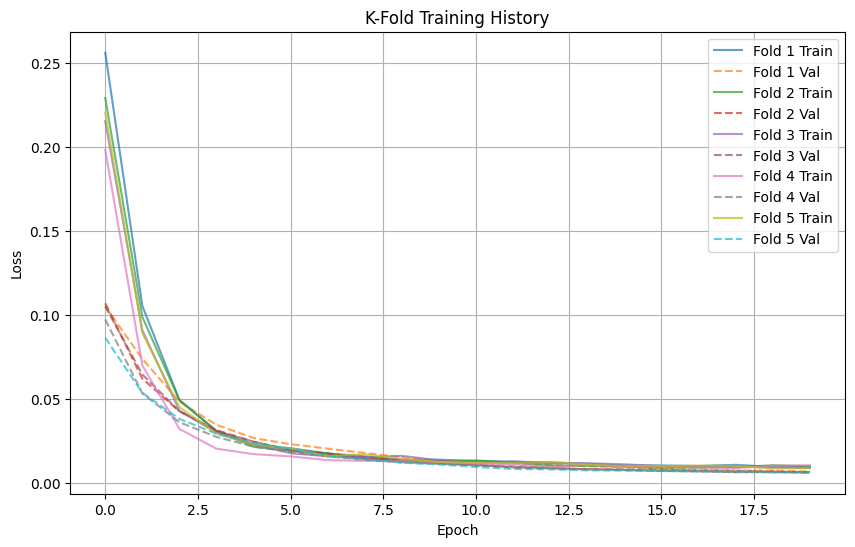

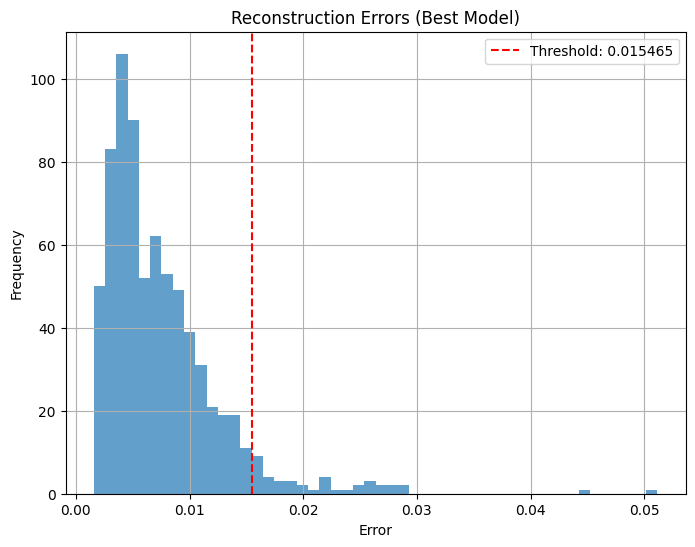

In [9]:
# Call it like this
plot_kfold_results(fold_histories, best_model, best_threshold)